In [1]:
import numpy as np
import pandas as pd
import json
import sklearn
from sklearn import utils, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import joblib
import math


In [2]:
# 1. 분석 데이터 준비 
org_df =pd.read_csv('ETL_DATA/OsanDataset.csv')
org_df.head()

# 2. 거리 가중치 반영  ->>  데이터셋 변환 및 병합시 부여 완료

,id,acc_sum,lon1,lat1,lon2,lat2,cctv,cross,speedBump,parking,...,youth,baby,build,latM,lonM,youchiwon,elementry,academy,gym,school_zone
0,0,0,126.994216,37.174182,126.995336,37.175089,0,0,0,0,...,0.0,0.0,0.0,37.173729,126.994776,0,0,0,0,0
1,1,0,126.994210,37.175084,126.995330,37.175990,0,0,0,0,...,0.0,0.0,0.0,37.174631,126.994770,0,0,0,0,0
2,2,0,126.994204,37.175985,126.995324,37.176891,0,0,0,0,...,0.0,0.0,0.0,37.175532,126.994764,0,0,0,0,0
3,3,0,126.994198,37.176887,126.995318,37.177793,0,0,0,0,...,0.0,0.0,0.0,37.176433,126.994758,0,0,0,0,0
4,4,0,126.995342,37.174187,126.996463,37.175093,0,0,0,0,...,0.0,0.0,0.0,37.173734,126.995902,0,0,0,0,0


In [3]:
# 3. 데이터프레임 분리 - 위치테이블 , 데이터테이블
id_df = org_df.loc[:,['id','lat1','lat2','lon1','lon2','latM','lonM']]
data_df = org_df.drop(columns=['lat1','lat2','lon1','lon2','latM','lonM']) 
data_df.head()

,id,acc_sum,cctv,cross,speedBump,parking,trafficLight,youth,baby,build,youchiwon,elementry,academy,gym,school_zone
0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0
1,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0
2,2,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0
3,3,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0
4,4,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0


In [4]:
# 4. 의미없는 데이터 열 삭제 , 데이터테이블의 id 반드시 살릴 것
list = []

for i in range(len(data_df['acc_sum'])) :
    sum = data_df.loc[i].sum() - data_df['id'][i]  
    if sum == 0 :
      list.append(i)

print(len(list)) 
before_df = data_df.drop(index=list) # [1562 rows x 11 columns]

1012


In [5]:
# 5. 섞기, 인덱스 재부여(반복문에 넣기 위해)
before_df = utils.shuffle(before_df)

before_df.reset_index(drop=True, inplace=True)
print(before_df.head()) 

     id  acc_sum  cctv  cross  speedBump  parking  trafficLight  youth  baby  \
0  2624        0     0      0          0        0             0    0.0   0.0   
1  2991        0     0      0          0        1             0   11.0   0.0   
2  1486        0     0      0          0        0             0    0.0   0.0   
3  1553        0     0      0          0        1             0    0.0   0.0   
4  2906        0     0      0          0        0             0    0.0   0.0   

     build  youchiwon  elementry  academy  gym  school_zone  
0     0.00          2          0        1    3            0  
1  6283.65          9          6        8    2            0  
2     0.00          6          0        2    0            0  
3     0.00          2          0        0    0            0  
4     0.00          1          1        7    3            0  


In [6]:
# 6. id 연계해서 모델에 돌리기 
id_list = before_df.loc[:,'id']
data_list = before_df.drop(columns=['acc_sum','id']) 
data_list = data_list[['youth','baby','build','youchiwon','elementry','gym','academy','school_zone','cctv','cross','parking','speedBump','trafficLight']]


import joblib
clf = joblib.load('OsanPredict_RF.dmp')
print(type(clf))
print('모델로딩성공')

result_list = []
per_list = []
grade_list = []

# 7. 결과 및 확률로 격자별 위험등급 부여
for i in range(len(data_list['youth'])) :
    data = [data_list.iloc[i].to_list()]

    result = clf.predict(data)[0]
    result_list.append(result)

    per = round(clf.predict_proba(data)[0][0]*100,2)
    per_list.append(per)

 # 사고가 나지 않을 확률을 기반으로 등급 부여   
    if result == 0:
        if per >= 90 :
            grade = 'N'
        elif per >= 70 :
            grade = 'D'
        elif per >= 60 :
            grade = 'C'
        elif per >= 55 :
            grade = 'B'
        else :
            grade = 'A'
    else :
        if 100 - per >= 90 :
            grade = 'N'
        elif 100 - per >= 70 :
            grade = 'D'
        elif 100 - per >= 60 :
            grade = 'C'
        elif 100 - per >= 55 :
            grade = 'B'
        else :
            grade = 'A'

    grade_list.append(grade)

after_list = data_list
after_list['id'] = id_list
after_list['result'] = result_list
after_list['per'] = per_list
after_list['grade'] = grade_list
print('위험등급부여완료')

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
모델로딩성공
위험등급부여완료


In [7]:
# 8. id를 pk로 생각하고 다시 좌표 부여 (시간다수소요)
empty_list = [0 for i in range(len(org_df['id']))]
org_df['result'] = empty_list
org_df['per'] = empty_list
org_df['grade'] = empty_list

org_df.head()

for i in range(len(org_df['id'])) :
    for k in range(len(after_list['id'])) :
        if org_df['id'][i] == after_list['id'][k] :
            org_df['result'][i] = after_list['result'][k]
            org_df['per'][i] = after_list['per'][k]
            org_df['grade'][i] = after_list['grade'][k]

org_df.head()
print('좌표 재부여 완료')

좌표 재부여 완료


A등급 지역 수 :95


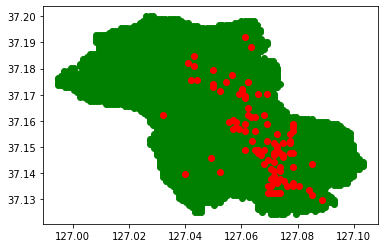

In [8]:
# 9-1. A 등급 분류 및 그래프로 확인
import matplotlib.pyplot as plt

is_A = org_df['grade'] == 'A'
result_A = org_df[is_A]
print('A등급 지역 수 :'+str(len(result_A)))

plt.plot(org_df['lonM'], org_df['latM'], 'go')
plt.plot(result_A['lonM'], result_A['latM'], 'ro')

plt.show()

In [9]:
# 9-2. A 등급 위험지역을 어린이보호구역 / 비구역으로 나누고 우선순위 정렬
# 확률을 사고가 일어날 확률로 모두 변환
result_A.reset_index(drop=True, inplace=True)
 
for i in range(len(result_A['youth'])) :
    if result_A['result'][i] == 0 :
        result_A['per'][i] = 100 - result_A['per'][i]
result_A = result_A.drop(columns=['result'])

# 위험등급 및 안전시설물 관련 데이터만 남기기
result_A = result_A[['acc_sum','grade','id','latM','lonM','school_zone','per','cross','parking','cctv','speedBump','trafficLight']]

# A 등급 중 어린이 보호구역인 지역 분류
is_sz = result_A['school_zone'] == 1
result_sz = result_A[is_sz]

# A 등급 중 어린이 보호구역 아닌 지역 분류
is_not = result_A['school_zone'] != 1
result_not = result_A[is_not]

# 사고 발생 이력 / 사고발생확률 / 횡단보도 수 / 불법주정차단속이력 로 내림차순 정렬
result_sz = result_sz.sort_values(by=['acc_sum','per','cross','parking'] ,ascending=False)
result_sz = result_sz.drop(columns=['per'])
result_sz.reset_index(drop=True, inplace=True)

result_not = result_not.sort_values(by=['acc_sum','per','cross','parking'] ,ascending=False)
result_not = result_not.drop(columns=['per'])
result_not.reset_index(drop=True, inplace=True)

In [10]:
# 10. csv로 결과 저장 
print(result_sz.head(20))
print(result_not.head(20))

# 오산시 전체 지역 데이터 저장
org_df.to_csv('RESULT/org.csv')

# 어린이 보호구역 중 어린이 보행중 교통사고 위험지역 20개 결과
result_sz.head(20).to_csv('RESULT/result_schoolzone.csv')

# 어린이 보호구역이 아닌 어린이 보행중 교통사고 위험지역 20개 결과
result_not.head(20).to_csv('RESULT/result_not.csv')



    acc_sum grade    id       latM        lonM  school_zone  cross  parking  \
0        10     A  3681  37.140688  127.073814            1      5     1354   
1         5     A  2925  37.169487  127.061262            1      3      328   
2         5     A  3689  37.147899  127.073774            1      4        9   
3         4     A  3415  37.132559  127.069356            1      4        4   
4         4     A  3874  37.157831  127.078223            1      2       21   
5         3     A  3145  37.161387  127.064687            1      2        0   
6         3     A  3831  37.155122  127.077111            1      2        0   
7         3     A  3212  37.148772  127.065886            1      3        3   
8         3     A  3483  37.132563  127.070482            1      2        3   
9         2     A  3872  37.156028  127.078233            1      2        3   
10        2     A  1580  37.182030  127.040911            1      0       46   
11        2     A  1652  37.175725  127.042075      

41
54


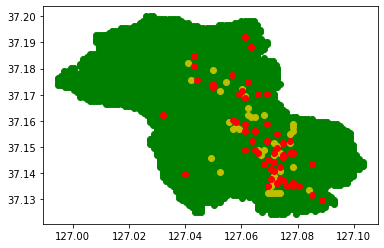

In [11]:
print(len(result_sz))
print(len(result_not))
plt.plot(org_df['lonM'], org_df['latM'], 'go')
plt.plot(result_sz['lonM'], result_sz['latM'], 'yo')
plt.plot(result_not['lonM'], result_not['latM'], 'ro')

plt.show()

In [21]:
# 제출을 위한 결과 csv
df1 = result_sz.head(20)
risk20 = range(1, 21, 1)
df1['우선순위'] = risk20 

df2 = result_not.head(20)
df2['우선순위'] = risk20 

merge = df1.append(df2)
print(merge)
merge.to_csv('RESULT/merge.csv')

    acc_sum grade    id       latM        lonM  school_zone  cross  parking  \
0        10     A  3681  37.140688  127.073814            1      5     1354   
1         5     A  2925  37.169487  127.061262            1      3      328   
2         5     A  3689  37.147899  127.073774            1      4        9   
3         4     A  3415  37.132559  127.069356            1      4        4   
4         4     A  3874  37.157831  127.078223            1      2       21   
5         3     A  3145  37.161387  127.064687            1      2        0   
6         3     A  3831  37.155122  127.077111            1      2        0   
7         3     A  3212  37.148772  127.065886            1      3        3   
8         3     A  3483  37.132563  127.070482            1      2        3   
9         2     A  3872  37.156028  127.078233            1      2        3   
10        2     A  1580  37.182030  127.040911            1      0       46   
11        2     A  1652  37.175725  127.042075      